#HW1 - Data Exploration and Preparation

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Part 1: Data Loading and First Look

In [65]:
!rm *.csv

from google.colab import files
print("Please load the raw csv data")
uploadedData = files.upload()
filename = list(uploadedData)[0]

Please load the raw csv data


Saving virus_data.csv to virus_data.csv


In [66]:
dataset = pd.read_csv(filename)

In [67]:
dataset.shape

(1250, 25)

In [68]:
#dataset['conversations_per_day'].value_counts()
dataset['household_income'].value_counts()

,count
household_income,
0.2,89
0.7,84
0.1,76
0.5,75
0.3,72
0.4,69
0.6,64
0.8,63
0.9,59


### Partitioning the data

In [69]:
!pip install scikit-learn
import sklearn
from sklearn.model_selection import train_test_split


train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=78)


## Part 2: Missing Values and Outliers

In [70]:
# calculate num of missing vals for each feature in both sets
nan_vals_train = train_set.isnull().sum()
nan_vals_test = test_set.isnull().sum()

features_missing_vals_train = nan_vals_train[nan_vals_train > 0]
features_missing_vals_test = nan_vals_test[nan_vals_test > 0]

# discard columns that don't have missing vals
nan_vals_train = nan_vals_train[features_missing_vals_train.index]
nan_vals_test = nan_vals_test[features_missing_vals_test.index]



print("training set missing values count:")
print(features_missing_vals_train)

print("\nMissing Values in Test Set:")
print(features_missing_vals_test)

training set missing values count:
household_income    103
PCR_02               56
dtype: int64

Missing Values in Test Set:
household_income    36
PCR_02              18
dtype: int64


In [71]:
def plot_box(series, title, xlabel):
 cleaned_series = series.dropna()
 plt.figure(figsize=(8, 6))
 plt.boxplot(cleaned_series,
vert=False)
 plt.xlabel(xlabel)
 plt.title(title)

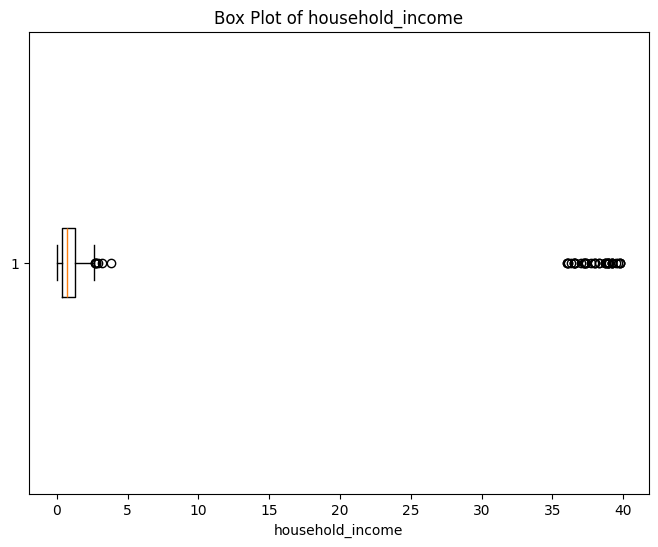

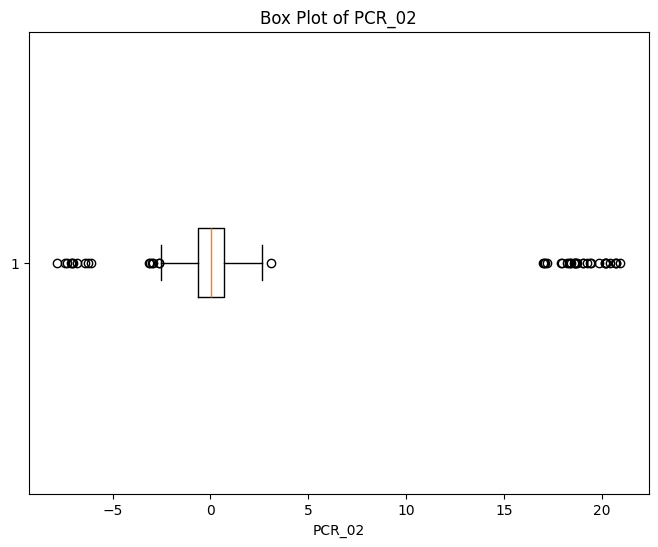

In [72]:
for feature in features_missing_vals_train.index:
  plot_box(series=train_set[feature], title=f"Box Plot of {feature}", xlabel=feature)

In [73]:
medians = train_set[features_missing_vals_train.index].median()
means = train_set[features_missing_vals_train.index].mean()

print("medians:\n")
print(medians)
print("\nmeans:\n")
print(means)

medians:

household_income    0.700000
PCR_02              0.033086
dtype: float64

means:

household_income    2.52029
PCR_02              0.53300
dtype: float64


In [74]:
for feature in features_missing_vals_train.index:
    median = train_set[feature].median()
    train_set[feature].fillna(median, inplace=True)

#replaces Nan values in test set with median (of train set)
for feature in features_missing_vals_test.index:
    median = train_set[feature].median()
    test_set[feature].fillna(median, inplace=True)

#missing_values_train_after = train_set[features_missing_vals_train.index].isnull().sum()
#missing_values_test_after = test_set[features_missing_vals_test.index].isnull().sum()
#print(missing_values_train_after)
#print(missing_values_test_after)

<ipython-input-74-19920dc03e6a>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_set[feature].fillna(median, inplace=True)
<ipython-input-74-19920dc03e6a>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

## Part 3: Warming Up with k-Nearest Neighbors

### Basic Data Exploration

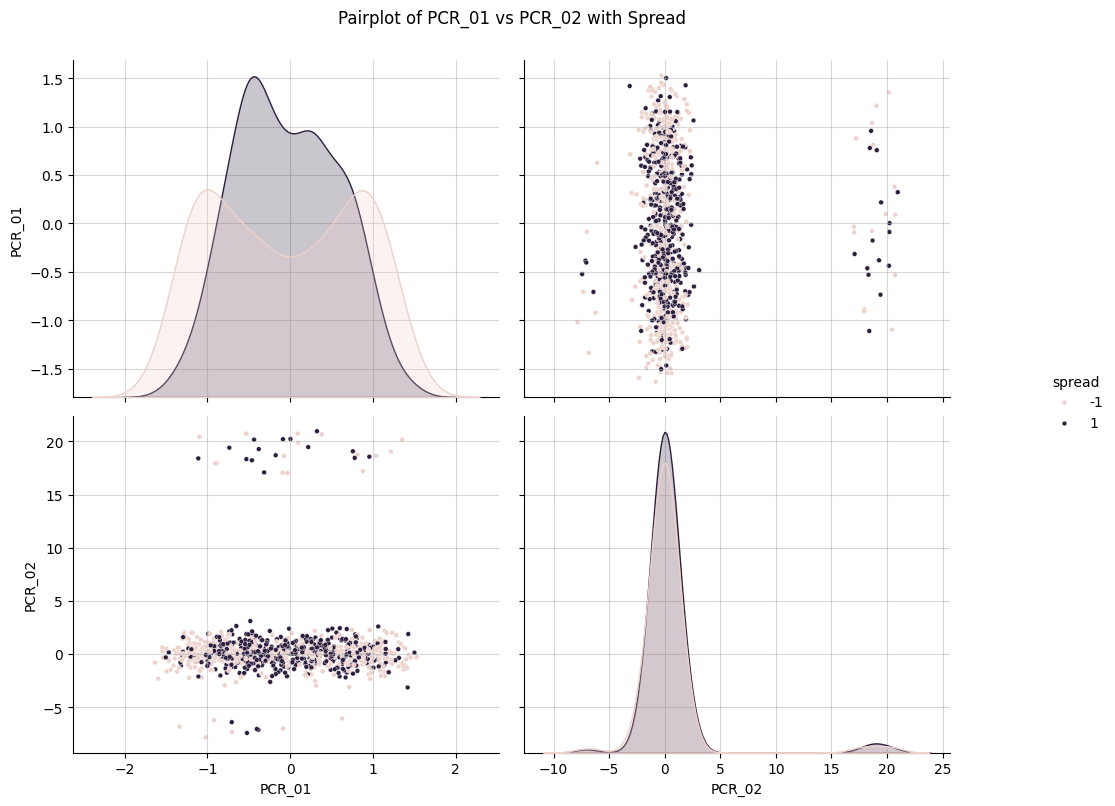

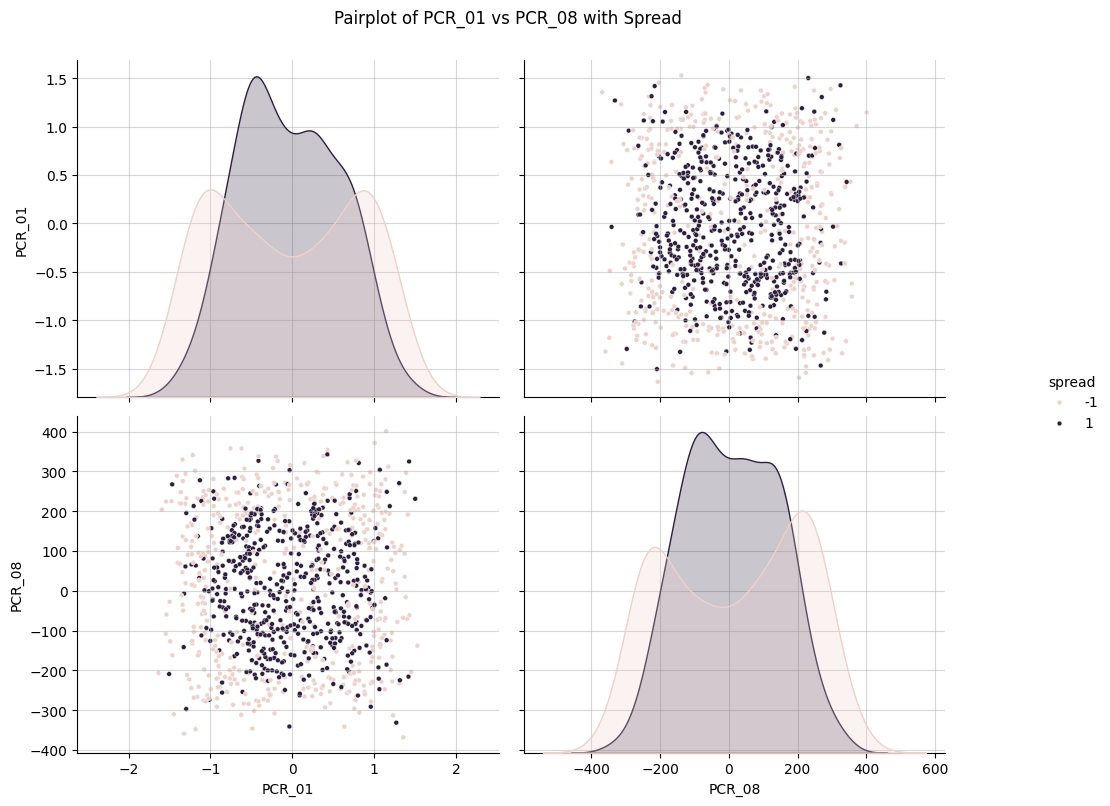

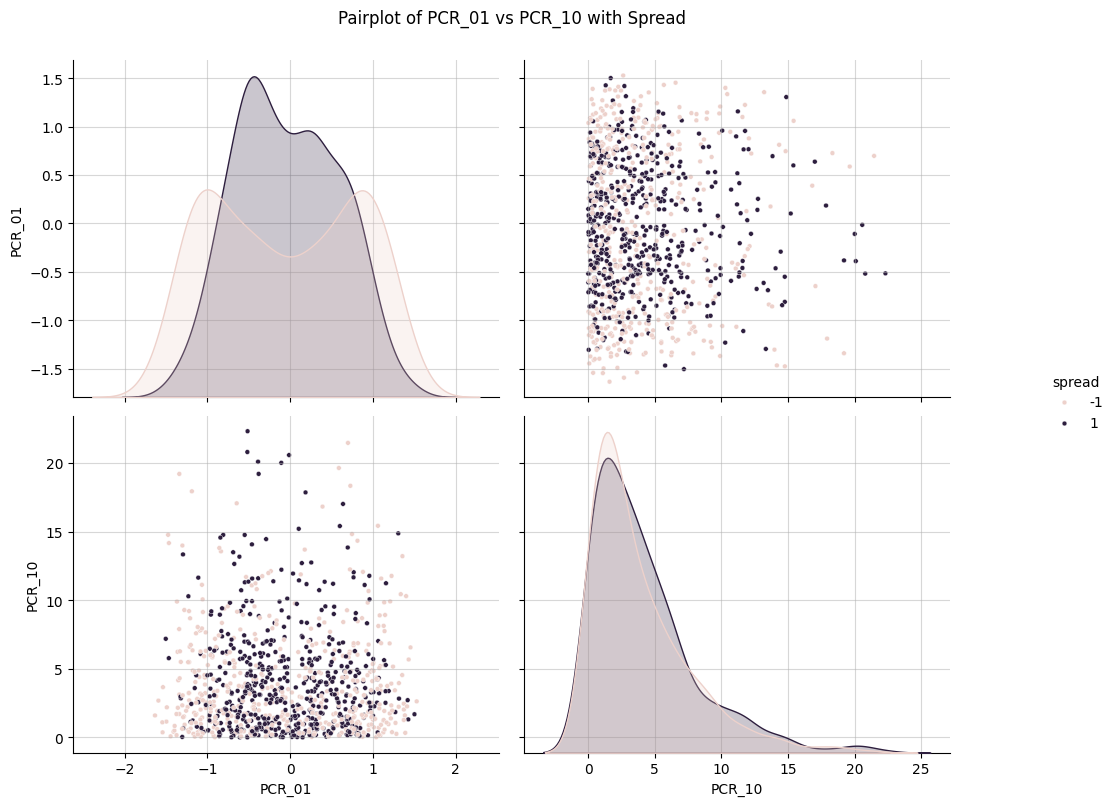

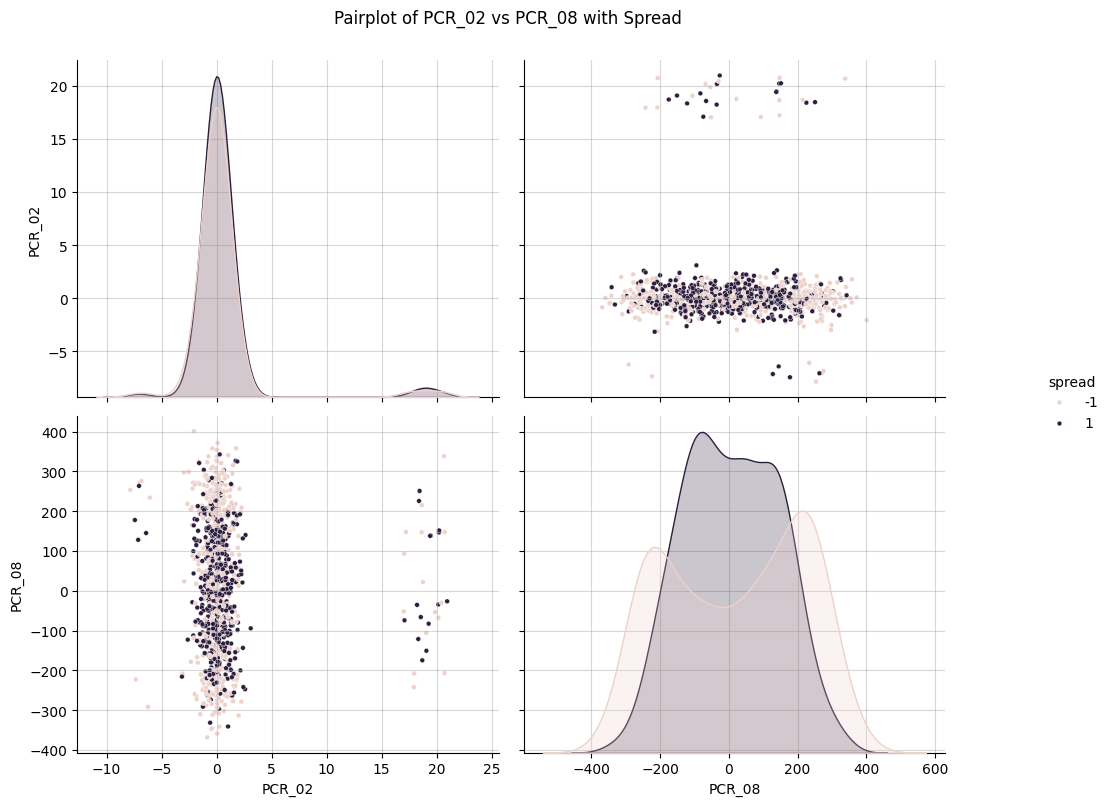

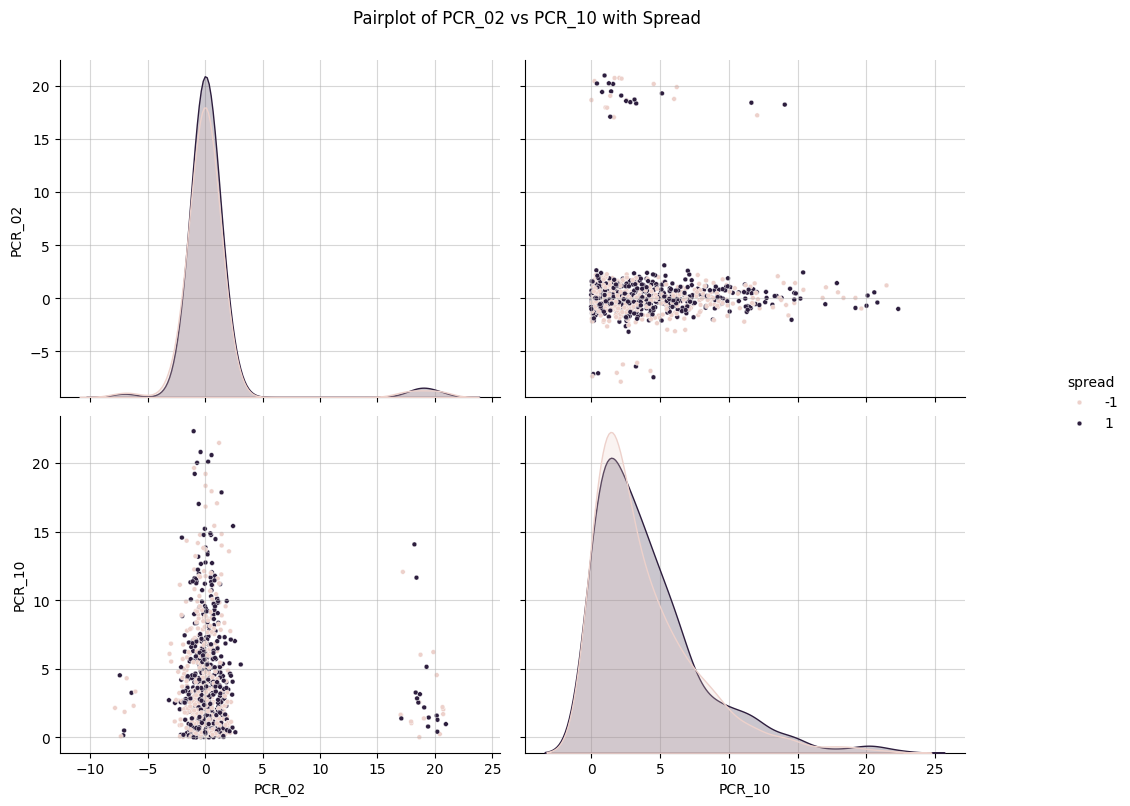

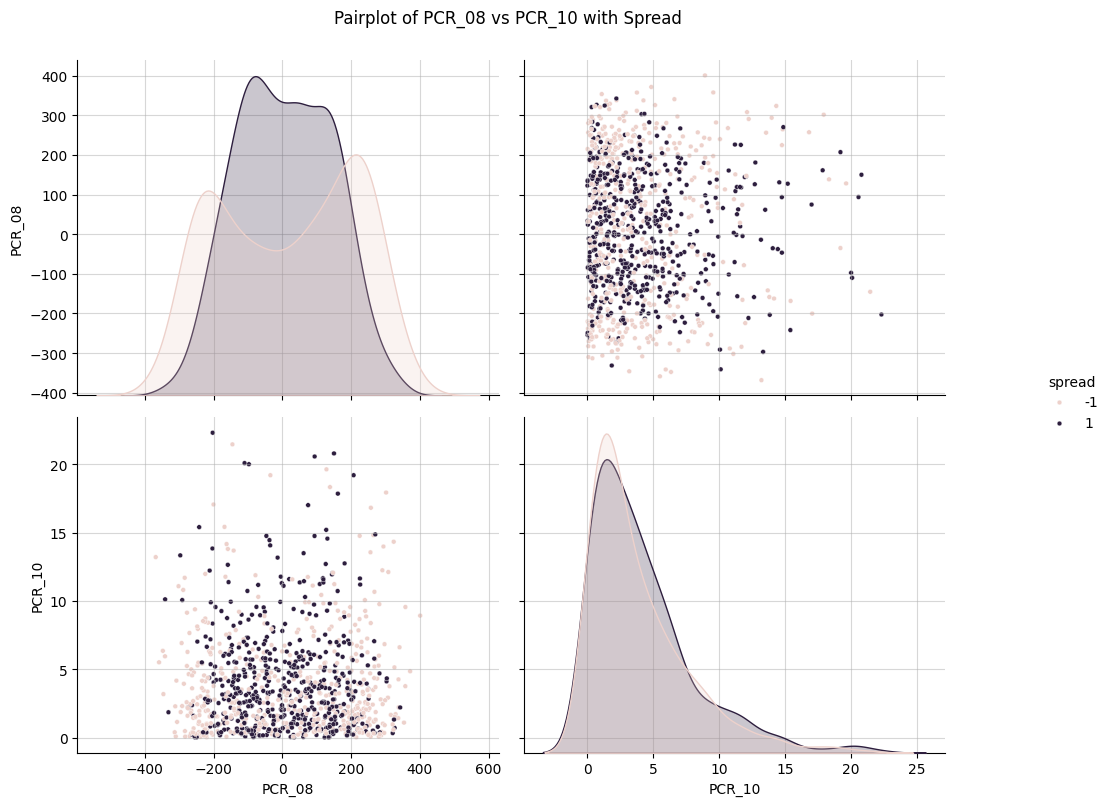

In [75]:
PCR_features = ['PCR_01','PCR_02','PCR_08','PCR_10']
PCR_pairs = []
#add to list all possible pairs
for i, feature1 in enumerate(PCR_features):
  for feature2 in PCR_features[i+1:]:
    PCR_pairs.append((feature1, feature2))
#plot all pairs
for x, y in PCR_pairs:
    g = sns.pairplot(
        data=train_set,
        vars=[x, y],
        hue='spread',
        plot_kws={"s": 12}
    )
    g.fig.suptitle(f"Pairplot of {x} vs {y} with Spread", y=1.04)
    for ax in np.ravel(g.axes):
        ax.grid(alpha=0.5)
    g.fig.set_size_inches(12, 8)
    plt.show()

In [76]:
chosen_pair = ['PCR_01','PCR_08']
#calculate correlation between chosen pair and spread.
correlations = train_set[chosen_pair + ['spread']].corr()
print(correlations)

          PCR_01    PCR_08    spread
PCR_01  1.000000 -0.004302  0.013725
PCR_08 -0.004302  1.000000 -0.035072
spread  0.013725 -0.035072  1.000000


### k-NN Implementation

In [77]:
from sklearn.base import BaseEstimator,ClassifierMixin
from scipy.spatial.distance import cdist
class kNN(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors:int = 3):
        self.n_neighbors = n_neighbors
    #k-NN is a lazy learner,so fit function just used to store the data
    def fit(self, X, y):
        self.X_train = np.copy(X)
        self.y_train = np.copy(y)
        return self

    def predict(self, X):
        #for each test sample, calculate the euclidean distance of each training samples to it.
        distances = cdist(X, self.X_train, metric='euclidean')

        #for each row (corresponds to test sample), move the k nearest training sample indices to beginning of array
        k_nearest_indices = np.argpartition(a=distances, kth=self.n_neighbors)

        #discard non neighbors from each row
        sliced_k_nearest_indices = k_nearest_indices[:,:self.n_neighbors]

        #get classes of k-nearest
        k_nearest = self.y_train[sliced_k_nearest_indices]

        #for each test sample, sum up classes of k-nearest neighbors.
        #If sum is positive or 0 then predict +1, if negative predict -1
        predictions = np.sign(np.sum(a=k_nearest, axis=1))

        predictions[predictions == 0] = 1

        return predictions

In [78]:
#given function
def visualize_clf(clf, X, Y, title,
                  xlabel, ylabel,
                  marker_size=50,
                  grid_length=300,
                  linewidths=None):
    import matplotlib.pyplot as plt
    import pandas as pd
    from matplotlib.colors import ListedColormap

    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()

    # For internal use here, make sure labels are 0 and 1
    Y = np.ravel(Y).astype(int)
    labels = set(Y)
    assert len(labels) == 2, "Can only visualize two unique labels"

    if labels == set([-1,1]):
      Y = (Y + 1) // 2
      labels = set(Y)

    assert labels == set([0,1]), "Could not handle given labels"

    plt.figure(figsize=(8, 8))

    # Parameters
    n_classes = 2
    markers = ["D", "o"]
    palette = sns.color_palette("hls", 2)
    custom_cmap = ListedColormap(palette.as_hex())

    x_delta = np.abs(X[:, 0].max() - X[:, 0].min()) * 0.1
    y_delta = np.abs(X[:, 1].max() - X[:, 1].min()) * 0.1
    x_min, x_max = X[:, 0].min() - x_delta, X[:, 0].max() + x_delta
    y_min, y_max = X[:, 1].min() - y_delta, X[:, 1].max() + y_delta
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_length),
                         np.linspace(y_min, y_max, grid_length))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cs = plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.35)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.75)

    # Plot the training points
    for i, color, marker in zip(labels, palette, markers):
        idx = np.where(Y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=color,
                    marker=marker,
                    edgecolor='white', s=marker_size,
                    linewidths=linewidths)

    plt.title(title, fontsize=20)
    plt.axis("tight")
    plt.show()


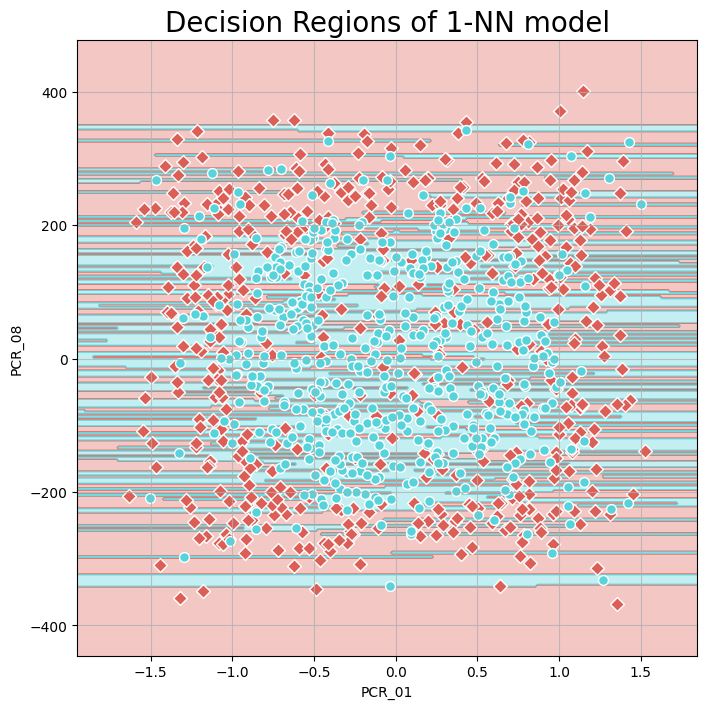

In [79]:
tmp_train_X = train_set[chosen_pair].copy()
tmp_train_y = train_set['spread'].copy()
kNN_model = kNN(n_neighbors=1)
kNN_model.fit(tmp_train_X, tmp_train_y)
visualize_clf(kNN_model, tmp_train_X, tmp_train_y, \
              title= "Decision Regions of 1-NN model", xlabel=chosen_pair[0], ylabel=chosen_pair[1])

In [80]:
train_accuracy = kNN_model.score(tmp_train_X, tmp_train_y)
test_accuracy = kNN_model.score(test_set[chosen_pair], test_set['spread'])
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Train Accuracy: 1.0
Test Accuracy: 0.644


### Data Normalization

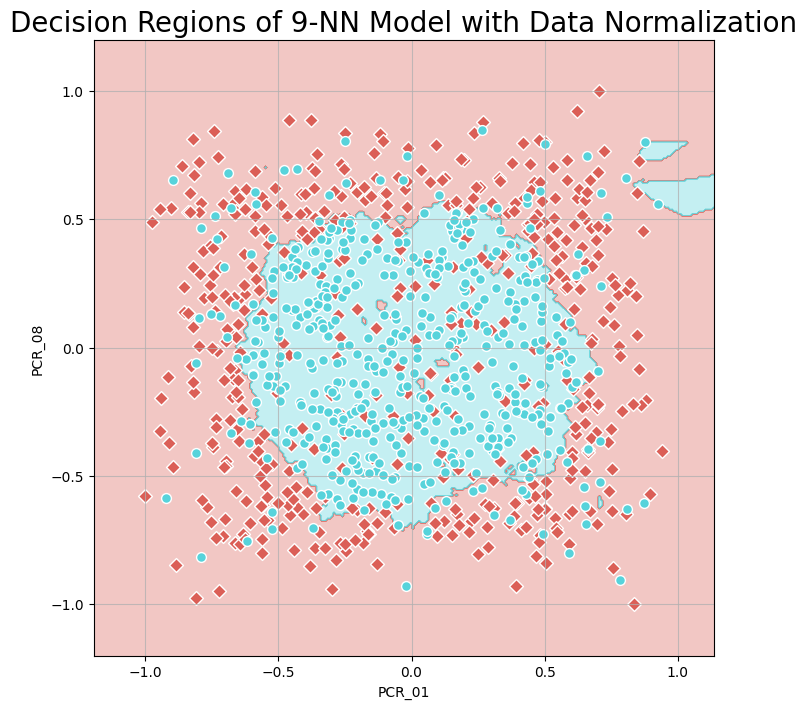

Train Accuracy: 0.803
Test Accuracy: 0.764


In [81]:
from sklearn.preprocessing import MinMaxScaler

#normalize the pair of features in dataset
normalized_dataset = dataset.copy()
normalized_dataset[chosen_pair] = MinMaxScaler(feature_range=(-1, 1)).fit_transform(dataset[chosen_pair])

#splitting normalized dataset with same seed as before
normalized_train_set, normalized_test_set = train_test_split(normalized_dataset, test_size=0.2, random_state=78)

normalized_X_train = normalized_train_set[chosen_pair]
normalized_y_train = normalized_train_set['spread']

normalized_X_test = normalized_test_set[chosen_pair]
normalized_y_test = normalized_test_set['spread']

#creating and fitting kNN model
normalized_kNN = kNN(n_neighbors=9)
normalized_kNN.fit(normalized_X_train, normalized_y_train)
visualize_clf(normalized_kNN, normalized_X_train, normalized_y_train, \
              title= "Decision Regions of " + str(normalized_kNN.n_neighbors) + "-NN Model with Data Normalization", xlabel=chosen_pair[0], ylabel=chosen_pair[1])
new_train_accuracy = normalized_kNN.score(normalized_X_train, normalized_y_train)
new_test_accuracy = normalized_kNN.score(normalized_X_test, normalized_y_test)
print(f"Train Accuracy: {new_train_accuracy}")
print(f"Test Accuracy: {new_test_accuracy}")

## Part 4: Data Exploration

# How to download from Colab?

In [ ]:
from google.colab import files
outputPath = "saved_file.csv"
dataset.to_csv(outputPath)
files.download(outputPath)